# Classificação de textos com spaCy

## Importação e instalação das bibliotecas

Neste notebook iremos trabalhar com classificação de textos utilizando 100% os recursos do spaCy.

O spaCy utiliza de recursos de redes neurais convolucionais para fazer a classificação.

Utilizaremos um dataset de frases em português anotados com dois rótulos: alegria e medo. Porém, **com este dataset não será possível ter uma pontuação muito boa**, pelo fato de que é **muito pequeno**. Para um modelo ser considerado bom deve ser alimentado com uma massa de dados bem maior do que apenas 196 frases (que é o caso desse nosso dataset de estudo).

**OBS.** É bem difícil encontrar bases de dados textuais em português. Em geral, quando é necessário desenvolver aplicações de PLN em português é necessário construir o próprio corpus (base de dados). Normalmente, a lingua comum em bases de dados encontradas é o inglês.

In [1]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [2]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
spacy.__version__

'3.8.7'

## Carregamento da base de dados

In [4]:
df = pd.read_csv('dataset/base_treinamento.txt', encoding='utf-8')
df.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


In [5]:
df.tail()

,texto,emocao
191,estou chocado e amedrontado com este assassina...,medo
192,é preciso afugenta com ímpeto este medo do inf...,medo
193,políticos usam suas forças para afugentar e am...,medo
194,o objetivo disso e apenas me amedrontar mais,medo
195,isso me apavora,medo


In [6]:
df.shape

(196, 2)

In [7]:
df['emocao'].value_counts()

emocao
alegria    112
medo        84
Name: count, dtype: int64

Text(0, 0.5, 'Contagem')

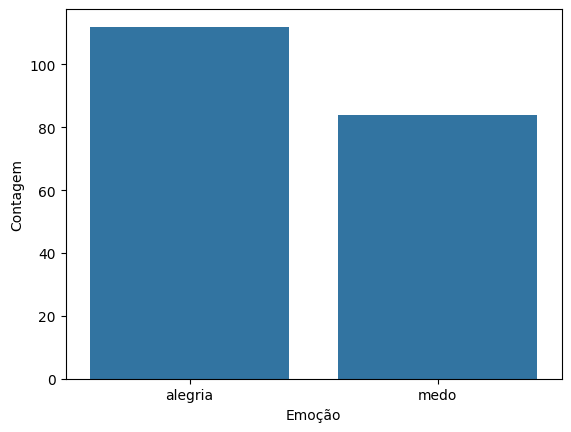

In [8]:
sns.countplot(df, x='emocao')
plt.xlabel('Emoção')
plt.ylabel('Contagem')

## Função para Pré-Processamento dos textos

Neste processo, dado um texto, iremos fazer o processo de remoçãod e pontuações e stopwords. Iremos utilizar alguns recursos que utilizamos no notebook *intro_spacy.ipynb*.

In [9]:
pontuacoes = string.punctuation
pontuacoes # Iremos remover todos estes caracteres dos textos

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS
len(stop_words)

416

In [11]:
# Instanciando o modelo spaCy
pln = spacy.load('pt_core_news_sm')

Ao invés de retornarmos as palavras originais, iremos retornar o *lemma* (lematização).

**OBS:**
A forma mostrada pelo prof para remover os stopwords e pontuações não funcionou tão bem, porém as propriedades *is_stop* e *is_punct* tiveram um efeito mais eficaz no dataset.

A função abaixo aplica a lematização, remove pontuações, stopwords e digitos numéricos.

In [12]:
def preprocessamento(texto: str):
    texto = texto.lower()
    doc = pln(texto) # Adiciona o texto para o modelo pln, para realizar o processamento posteriormente
    lista: list[str] = [] # A ideia é adicionar os valores já processados dentro dessa lista
    
    for token in doc:
        if not token.is_stop and not token.is_punct:
            lista.append(token.lemma_) # Adiciona o lemma das palavras
            
    #lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in pontuacoes]
    
    lista = ' '.join(str(palavra) for palavra in lista if not palavra.isdigit()) # isdigit() remove os digitos numéricos
    
    return lista

Caso de teste (estranho):

Quando não é colocado ponto final na frase: *"Estou aprendendo processamento de linguagem natural, Curso em Curitiba"*, a palavra "curitiba" fica "curitber" (?). Portanto, colocando o ponto final na frase, resolveu este problema estranho.

In [13]:
teste = preprocessamento("Estou aPrendendo processamento de linguagem natural, Curso em Curitiba")
teste

'aprender processamento linguagem natural curso curitber'

In [14]:
teste = preprocessamento("Estou aPrendendo processamento de linguagem natural, Curso em Curitiba, em 12 de Setembro.")
teste

'aprender processamento linguagem natural curso curitiba setembro'

## Pré-processamento da base de dados

In [15]:
df['texto_processado'] = [preprocessamento(texto) for texto in df['texto']]

In [16]:
# o professor fez assim, forma interessante com o "apply":
df['texto_processado'] = df['texto'].apply(preprocessamento) # não é necessário passar explicitamente o parametro texto

In [17]:
df.head()

,texto,emocao,texto_processado
0,este trabalho é agradável,alegria,trabalho agradável
1,gosto de ficar no seu aconchego,alegria,gostar ficar aconchego
2,fiz a adesão ao curso hoje,alegria,fiz adesão curso hoje
3,eu sou admirada por muitos,alegria,admirar
4,adoro como você,alegria,adorar


## Tratamento da classe

Precisamos deixar a nossa base de dados com a mesma estrutura abaixo (requerida pelo spaCy), para então depois enviar para o modelo de deep learning do spaCy.

In [18]:
exemplo_base_dados = [["este trabalho é agradável", {"ALEGRIA": True, "MEDO": False}],
                      ["este lugar continua assustador", {"ALEGRIA": False, "MEDO": True}]]
type(exemplo_base_dados)

list

In [19]:
exemplo_base_dados[0]

['este trabalho é agradável', {'ALEGRIA': True, 'MEDO': False}]

In [20]:
# Apply para gerar o formato padrão dos rótulos
textos, rotulos = df['texto_processado'], df['emocao'].apply(lambda x: {"ALEGRIA": True, "MEDO": False} if x == 'alegria' else {"ALEGRIA": False, "MEDO": True})

# zip para juntar textos e rótulos, retorna um array com os dois dados necessários: X (texto, variável independente) e y (rótulo, variável dependente)
base_dados_final = [[x, y] for x, y, in zip(textos, rotulos)]
base_dados_final[0], df['texto'][0], df['emocao'][0]

(['trabalho agradável', {'ALEGRIA': True, 'MEDO': False}],
 'este trabalho é agradável',
 'alegria')

In [21]:
base_dados_final[150], df['texto'][150], df['emocao'][150]

(['ei cuidado bater poste', {'ALEGRIA': False, 'MEDO': True}],
 'ei cuidado você vai bater no poste!',
 'medo')

In [22]:
len(base_dados_final)

196

## Criação do classificador (rede neural)

In [23]:
from spacy.training import Example

modelo = spacy.blank('pt')

categorias = modelo.add_pipe('textcat') # textcat = categorização de texto | Se as labels puderem ser ambas verdadeiras (multilabel), usar "textcat_multilabel"

# Adiciona os tipos de rótulos
categorias.add_label('ALEGRIA')
categorias.add_label('MEDO')

1

In [ ]:
historico = []
otimizador = modelo.initialize() # usar modelo.resume_training() para um modelo pré-treinado

for epoca in range(1000):
    random.shuffle(base_dados_final)
    losses = {}

    for batch in spacy.util.minibatch(base_dados_final, size=30): # Terá batch size de 30 (ou seja, atualizará os pesos de 30 em 30)
        examples = []

        for texto, entities in batch:
            doc = modelo.make_doc(texto) # cria doc simples sem predições, com tokenização

            # Converte booleanos para float
            cats = {label: 1.0 if value else 0.0 for label, value in entities.items()}
            annotations = {'cats': cats}

            # Cada item do batch é transformado em um objeto Example do spaCy
            example = Example.from_dict(doc, annotations) # Isto une o texto tokenizado e as anotações
            examples.append(example)

        # Atualização dos pesos (na versão 3.x do spaCy, é necessário passar uma lista de objetos "Example")
        modelo.update(examples, sgd=otimizador, losses=losses)

    if epoca % 100 == 0: # A cada 100 épocas mostra a época atual e adiciona no histórico
        print(losses)
        historico.append(losses)

{'textcat': 1.7156134694814682}
{'textcat': 2.2804322666325483e-11}
{'textcat': 3.0365062677825683e-12}
{'textcat': 8.019679213246145e-13}
{'textcat': 2.8741754392073646e-13}
{'textcat': 1.166766327854291e-13}
{'textcat': 5.728579240542341e-14}
{'textcat': 2.9582479781431275e-14}
{'textcat': 1.4791390133184657e-14}
{'textcat': 7.714530814614378e-15}


In [ ]:
historico_loss = [h.get('textcat') for h in historico]
np.array(historico_loss)

array([1.71561347e+00, 2.28043227e-11, 3.03650627e-12, 8.01967921e-13,
       2.87417544e-13, 1.16676633e-13, 5.72857924e-14, 2.95824798e-14,
       1.47913901e-14, 7.71453081e-15])

Text(0, 0.5, 'Erro')

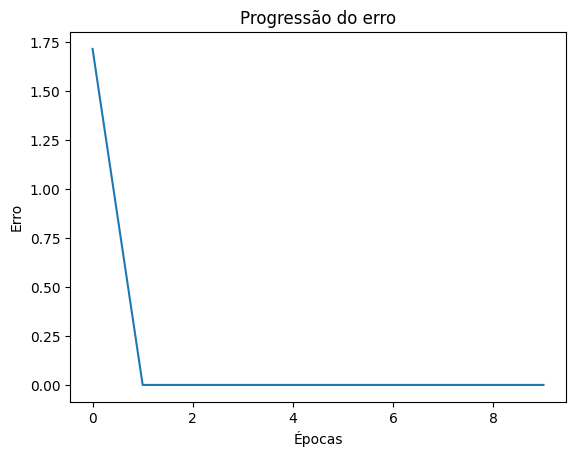

In [ ]:
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [25]:
modelo.to_disk("modelo_alegria_medo") # Será gerado uma pasta com os pesos e arquivos necessários

## Testes com uma frase

In [24]:
modelo_treinado = spacy.load("modelo_alegria_medo")
modelo_treinado

In [25]:
texto_alegria = "eu adoro a cor dos seus olhos"

texto_alegria = preprocessamento(texto_alegria)
texto_alegria

'adorar cor olho'

In [26]:
previsao = modelo_treinado(texto_alegria)
previsao

adorar cor olho

In [27]:
previsao.cats # 100% de certeza que o sentimento é de alegria

{'ALEGRIA': 1.0, 'MEDO': 2.8992026557261852e-08}

In [28]:
texto_medo = "estou com medo dele"

previsao = modelo_treinado(preprocessamento(texto_medo))
previsao.cats

{'ALEGRIA': 2.2099307273037994e-07, 'MEDO': 0.9999997615814209}

## Avaliação do modelo

In [ ]:
rotulos = df['emocao']

### Avaliação na base de treinamento

In [35]:
previsoes = []

for texto in df['texto_processado']:
    prev = modelo_treinado(preprocessamento(texto))
    previsoes.append(prev.cats)

In [39]:
previsoes_treino = ["alegria" if prev['ALEGRIA'] > prev['MEDO'] else "medo" for prev in previsoes]

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [43]:
accuracy_score(rotulos, previsoes_treino)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

### Avaliação na base de teste